In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter

In [2]:
mu = np.array([0.5, 0])
Sigma = np.array([[0.1**2, 0], [0, 0.2**2]])  # identity matrix for rho = 0
Sigma_inv = np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)

# Multivariate normal density function using matrix form
def bivariate_normal(pos, mu, Sigma_inv, Sigma_det):
    diff = pos - mu
    exponent = -0.5 * np.einsum('...k,kl,...l->...', diff, Sigma_inv, diff)
    return 0.0565+0.9*np.exp(exponent)

In [3]:
def U_eq(rho):
    return u_max*(1-rho/rho_max)
def V_eq(rho, y):
    return v_max*(np.exp(-(b+y)/2)-np.exp(-(b-y)/2))*(1-rho/rho_max)
    
def FPK(m, n, o, dt, dx, dy, rho, u, v, d1, d2, sigma):
    for j in range(m-1):
        for i in range(n):
            for l in range(o):
                if i == n-1:
                    if l == 0:
                        rho[j+1, i, l] = 1/4*(rho[j, 0, l]+rho[j, i-1, l]+2*rho[j, i, l+1])-dt/(2*dx)*(rho[j, 0, l]*(u[j, 0, l]+d1[j, 0, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l+1]-2*rho[j, i, l])
                    elif l==o-1:
                        rho[j+1, i, l] = 1/4*(rho[j, 0, l]+rho[j, i-1, l]+2*rho[j, i, l-1])-dt/(2*dx)*(rho[j, 0, l]*(u[j, 0, l]+d1[j, 0, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l-1]-2*rho[j, i, l])
                    else:
                        rho[j+1, i, l] = 1/4*(rho[j, 0, l]+rho[j, i-1, l]+rho[j, i, l+1]+rho[j, i, l-1])-dt/(2*dx)*(rho[j, 0, l]*(u[j, 0, l]+d1[j, 0, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))-dt/(2*dy)*(rho[j, i, l+1]*(v[j, i, l+1]+d1[j, i, l+1])-rho[j, i, l-1]*(v[j, i, l-1]+d2[j, i, l-1]))+sigma**2*dt/(dy**2)*(rho[j, i, l+1]-2*rho[j, i, l]+rho[j, i, l-1])
                else:
                    if l == 0:
                        rho[j+1, i, l] = 1/4*(rho[j, i+1, l]+rho[j, i-1, l]+2*rho[j, i, l+1])-dt/(2*dx)*(rho[j, i+1, l]*(u[j, i+1, l]+d1[j, i+1, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l+1]-2*rho[j, i, l])
                    elif l==o-1:
                        rho[j+1, i, l] = 1/4*(rho[j, i+1, l]+rho[j, i-1, l]+2*rho[j, i, l-1])-dt/(2*dx)*(rho[j, i+1, l]*(u[j, i+1, l]+d1[j, i+1, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l-1]-2*rho[j, i, l])
                    else:
                        rho[j+1, i, l] = 1/4*(rho[j, i+1, l]+rho[j, i-1, l]+rho[j, i, l+1]+rho[j, i, l-1])-dt/(2*dx)*(rho[j, i+1, l]*(u[j, i+1, l]+d1[j, i+1, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))-dt/(2*dy)*(rho[j, i, l+1]*(v[j, i, l+1]+d2[j, i, l+1])-rho[j, i, l-1]*(v[j, i, l-1]+d2[j, i, l-1]))+sigma**2*dt/(dy**2)*(rho[j, i, l+1]-2*rho[j, i, l]+rho[j, i, l-1])
    return rho

                        
def HJBI(m, n, o, b, dt, dx, dy, rho, u, v, d1, d2, C, sigma, k = 1):
    y = np.linspace(-b, b, o)
    alpha = 1/(2*k**4)*(2*k**2-1-2*k**4)
    for j in range(m-2, -1, -1):
        for i in range(n):
            for l in range(o):
                if i == n-1:
                    if l==0:
                        C[j, i, l] = C[j+1, i, l]+alpha*dt*((C[j+1, 0, l]-C[j+1, i-1, l])**2/(4*dx**2))+dt*U_eq(rho[j+1, i, l])*(C[j+1, 0, l]-C[j+1, i-1, l])/(2*dx)+dt*sigma**2/dy**2*(2*C[j+1, i, l+1]-2*C[j+1, i, l])
                    elif l == o-1:
                        C[j, i, l] = C[j+1, i, l]+alpha*dt*((C[j+1, 0, l]-C[j+1, i-1, l])**2/(4*dx**2))+dt*U_eq(rho[j+1, i, l])*(C[j+1, 0, l]-C[j+1, i-1, l])/dx+dt*sigma**2/dy**2*(2*C[j+1, i, l-1]-2*C[j+1, i, l])
                    else:
                        C[j, i, l] = C[j+1, i, l]+alpha*dt*((C[j+1, 0, l]-C[j+1, i-1, l])**2/(4*dx**2)+(C[j+1, i, l+1]-C[j+1, i, l-1])**2/(4*dy**2))+dt/(2*dx)*U_eq(rho[j+1, i, l])*(C[j+1, 0, l]-C[j+1, i-1, l])+dt/(2*dy)*V_eq(rho[j+1, i, l], y[l])*(C[j+1, i, l+1]-C[j+1, i, l-1])+sigma**2*dt/(dy**2)*(C[j+1, i, l+1]-2*C[j+1, i, l]+C[j+1, i, l-1])
                else:
                    if l==0:
                        C[j, i, l] = C[j+1, i, l]+alpha*dt*((C[j+1, i+1, l]-C[j+1, i-1, l])**2/(4*dx**2))+dt*U_eq(rho[j+1, i, l])*(C[j+1, i+1, l]-C[j+1, i-1, l])/(2*dx)+dt*sigma**2/dy**2*(2*C[j+1, i, l+1]-2*C[j+1, i, l])
                    elif l == o-1:
                        C[j, i, l] = C[j+1, i, l]+alpha*dt*((C[j+1, i+1, l]-C[j+1, i-1, l])**2/(4*dx**2))+dt*U_eq(rho[j+1, i, l])*(C[j+1, i+1, l]-C[j+1, i-1, l])/dx+dt*sigma**2/dy**2*(2*C[j+1, i, l-1]-2*C[j+1, i, l])
                    else:
                        C[j, i, l] = C[j+1, i, l]+alpha*dt*((C[j+1, i+1, l]-C[j+1, i-1, l])**2/(4*dx**2)+(C[j+1, i, l+1]-C[j+1, i, l-1])**2/(4*dy**2))+dt/(2*dx)*U_eq(rho[j+1, i, l])*(C[j+1, i+1, l]-C[j+1, i-1, l])+dt/(2*dy)*V_eq(rho[j+1, i, l], y[l])*(C[j+1, i, l+1]-C[j+1, i, l-1])+sigma**2*dt/(dy**2)*(C[j+1, i, l+1]-2*C[j+1, i, l]+C[j+1, i, l-1])
    for j in range(m):
        for i in range(n):
            for l in range(o):
                if i == n-1:
                    if l == 0:
                        u[j, i, l] = np.clip(U_eq(rho[j, i, l])-1/(2*dx)*(C[j, 0, l]-C[j, i-1, l]), 0, u_max)
                        v[j, i, l] = np.clip(V_eq(rho[j, i, l], y[l]), -v_max, v_max)
                        d1[j, i, l] = 1/(2*k**2)*1/(2*dx)*(C[j, 0, l]-C[j, i-1, l])
                        d2[j, i, l] = 0
                    elif l == o-1:
                        u[j, i, l] = np.clip(U_eq(rho[j, i, l])-1/(2*dx)*(C[j, 0, l]-C[j, i-1, l]), 0, u_max)
                        v[j, i, l] = np.clip(V_eq(rho[j, i, l], y[l]), -v_max, v_max)
                        d1[j, i, l] = 1/(2*k**2)*1/(2*dx)*(C[j, 0, l]-C[j, i-1, l])
                        d2[j, i, l] = 0
                    else:
                        u[j, i, l] = np.clip(U_eq(rho[j, i, l])-1/(2*dx)*(C[j, 0, l]-C[j, i-1, l]), 0, u_max)
                        v[j, i, l] = np.clip(V_eq(rho[j, i, l], y[l])-1/(2*dy)*(C[j, i, l+1]-C[j, i, l-1]), -v_max, v_max)
                        d1[j, i, l] = 1/(2*k**2)*1/(2*dx)*(C[j, 0, l]-C[j, i-1, l])
                        d2[j, i, l] = 1/(2*k**2)**1/(2*dy)*(C[j, i, l+1]-C[j, i, l-1])
                else:
                    if l == 0:
                        u[j, i, l] = np.clip(U_eq(rho[j, i, l])-1/(2*dx)*(C[j, i+1, l]-C[j, i-1, l]), 0, u_max)
                        v[j, i, l] = np.clip(V_eq(rho[j, i, l], y[l]), -v_max, v_max)
                        d1[j, i, l] = 1/(2*k**2)*1/(2*dx)*(C[j, i+1, l]-C[j, i-1, l])
                        d2[j, i, l] = 0
                    elif l == o-1:
                        u[j, i, l] = np.clip(U_eq(rho[j, i, l])-1/(2*dx)*(C[j, i+1, l]-C[j, i-1, l]), 0, u_max)
                        v[j, i, l] = np.clip(V_eq(rho[j, i, l], y[l]), -v_max, v_max)
                        d1[j, i, l] = 1/(2*k**2)*1/(2*dx)*(C[j, i+1, l]-C[j, i-1, l])
                        d2[j, i, l] = 0
                    else:
                        u[j, i, l] = np.clip(U_eq(rho[j, i, l])-1/(2*dx)*(C[j, i+1, l]-C[j, i-1, l]), 0, u_max)
                        v[j, i, l] = np.clip(V_eq(rho[j, i, l], y[l])-1/(2*dy)*(C[j, i, l+1]-C[j, i, l-1]), -v_max, v_max)
                        d1[j, i, l] = 1/(2*k**2)*1/(2*dx)*(C[j, i+1, l]-C[j, i-1, l])
                        d2[j, i, l] = 1/(2*k**2)**1/(2*dy)*(C[j, i, l+1]-C[j, i, l-1])
    return C, u, v, d1, d2

def fictitious_play(iter, Cold, Cnew, uold, unew, vold, vnew, d1old, d1new, d2old, d2new):
    Cnew = iter/(iter+1)*Cnew+1/(iter+1)*Cold
    unew = iter/(iter+1)*unew+1/(iter+1)*uold
    vnew = iter/(iter+1)*vnew+1/(iter+1)*vold
    d1new = iter/(iter+1)*d1new+1/(iter+1)*d1old
    d2new = iter/(iter+1)*d2new+1/(iter+1)*d2old
    return Cnew, unew, vnew, d1new, d2new

Current grid size: 320 x 80 x 80
Iteration: 100 Error: 4.297015788458573e-14
0.0369334035528552
-0.0369334035528552
0.969
0.16467275113558616
Processing  100.0% complete(/)


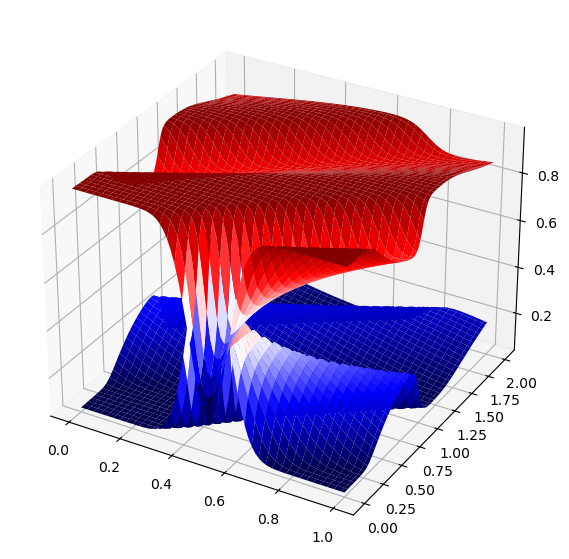

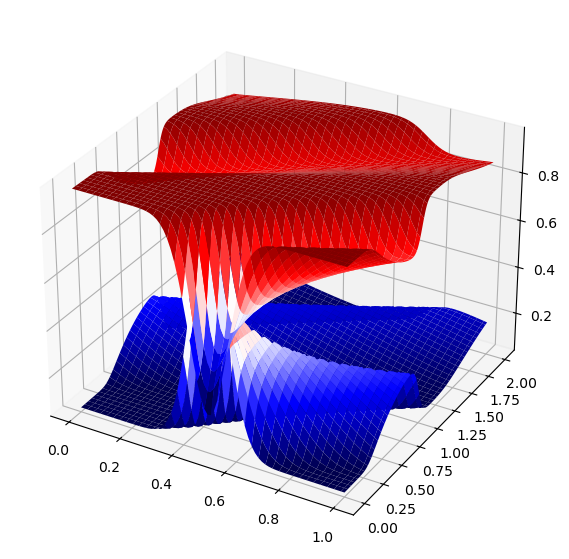

Time elapsed: 4904.751489400864  seconds


In [5]:
u_max = 1.02
rho_max = 1.13
v_max = 0.15
m = 320
n = 80
o = 80
b = 0.3
k = 1
sigma = 0.01
T_max = 2
L = 1
x = np.linspace(0, L, n)
y = np.linspace(-b, b, o)
t = np.linspace(0, T_max, m)
dt = t[1]-t[0]
dy = y[1]-y[0]
dx = x[1]-x[0]
Y, X = np.meshgrid(y, x)
rhoold = np.zeros((m, n, o))
Z = 0.0565+0.9*np.exp(-1/2*(X-0.5)**2/0.07**2-1/2*Y**2/0.035**2)
rhoold[0]= Z
Cold = np.ones((m, n, o))
uold = np.zeros_like(Cold)
vold = np.zeros_like(uold)
d1old = np.zeros_like(uold)
d2old = np.zeros_like(uold)
max_iter = 100
start = time.time()
print("Starting the Fixed Point Iteration")
for iter in range(max_iter):
    rhonew = FPK(m, n, o, dt, dx, dy, rhoold, uold, vold, d1old, d2old, sigma)
    Cnew, unew, vnew, d1new, d2new = HJBI(m, n, o, b, dt, dx, dy, rhoold, uold, vold, d1old, d2old, Cold, sigma)
    Cnew, unew, vnew, d1new, d2new = fictitious_play(iter, Cold, Cnew, uold, unew, vold, vnew, d1old, d1new, d2old, d2new)
    error = np.linalg.norm(rhonew-rhoold)+np.linalg.norm(unew-uold)+np.linalg.norm(vnew-vold)+np.linalg.norm(d1new-d1old)+np.linalg.norm(d2new-d2old)
    clear_output(wait=True)
    print('Current grid size:', m,'x',n,'x',o)
    print('Iteration:', iter+1, 'Error:', error)
    print(np.max(vold))
    print(np.min(vold))
    print(np.max(uold))
    print(np.min(uold))
    if iter%3 == 0:
        print('Processing ', np.round((iter+1)/max_iter*100, 2),'\b% complete(/)')
    if iter%3 == 1:
        print('Processing ', np.round((iter+1)/max_iter*100, 2),'\b% complete(–)')
    if iter%3 == 2:
        print('Processing ', np.round((iter+1)/max_iter*100, 2),'\b% complete(\\)')
    X, T = np.meshgrid(x, t)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, uold[:, :, int(o/2)], cmap='seismic')
    ax.plot_surface(X, T, rhoold[:, :, int(o/2)], cmap='seismic')
    plt.show()
    rhoold = rhonew
    uold = unew
    vold = vnew
    Cold = Cnew
    d1old = d1new
    d2old = d2new
    uold = gaussian_filter(uold, sigma=(1, 1, 1))
    vold = gaussian_filter(vold, sigma=(1, 1, 1))
    d1old = gaussian_filter(d1old, sigma=(1, 1, 1))
    d2old = gaussian_filter(d2old, sigma=(1, 1, 1))
    Cold = gaussian_filter(Cold, sigma=(1, 1, 1))
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, uold[:, :, int(o/2)], cmap='seismic')
ax.plot_surface(X, T, rhoold[:, :, int(o/2)], cmap='seismic')
plt.show()
print('Time elapsed:', time.time()-start, ' seconds')

In [13]:
import pandas as pd
rho1 = rhoold.reshape(320, 6400)
u1 = uold.reshape(320, 6400)
v1 = vold.reshape(320, 6400)
pd.DataFrame(rho1).to_csv('MFG_LWR_density.csv', index = False)
pd.DataFrame(u1).to_csv('MFG_LWR_velocityu.csv', index = False)
pd.DataFrame(v1).to_csv('MFG_LWR_velocityv.csv', index = False)

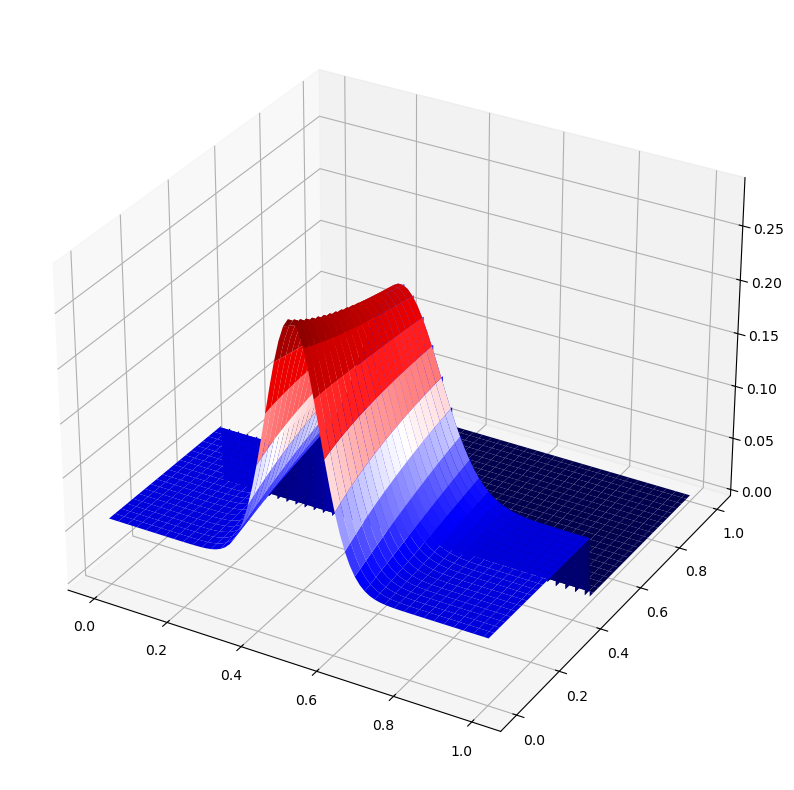

In [30]:
x = np.linspace(0, 1, n)
t = np.linspace(0, 1, int(m/2))
X, T = np.meshgrid(x, t)
# X, Y = np.meshgrid(x, y)
# Define the function
# U = rho[:, :, 50]
Z =rhoold[:int(m/2), :, 20]
# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, Z, cmap='seismic')
# plt.savefig('initial_profile.png', format = 'png', dpi = 600)
# Labels
# ax.set_xlabel('x')
# ax.set_ylabel('t')
# ax.set_zlabel('u(x, t)')
# ax.set_title('Surface plot of u(x, t) = sin(πx) * exp(-t)')
# ax.view_init(elev = 25, azim= 200)

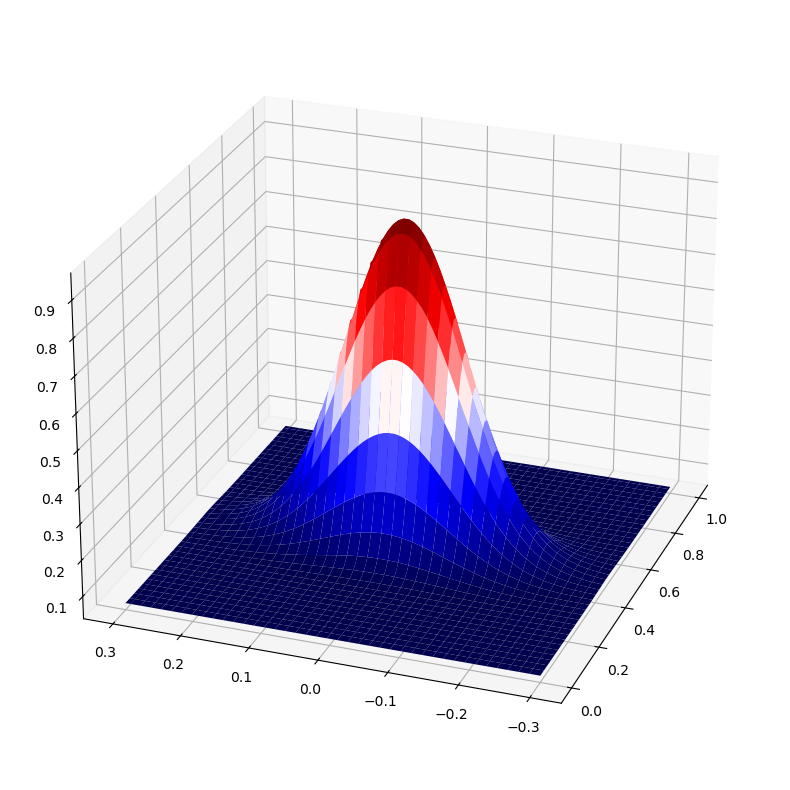

In [31]:
x = np.linspace(0, 1, n)
t = np.linspace(0, 3, m)
Y, X = np.meshgrid(y, x)
# X, Y = np.meshgrid(x, y)
# Define the function
# U = rho[:, :, 50]
Z =rhoold[0]
# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='seismic')
# plt.savefig('initial_profile.png', format = 'png', dpi = 600)
# Labels
# ax.set_xlabel('x')
# ax.set_ylabel('t')
# ax.set_zlabel('u(x, t)')
# ax.set_title('Surface plot of u(x, t) = sin(πx) * exp(-t)')
ax.view_init(elev = 25, azim= 200)

In [69]:
Y, X = np.meshgrid(y, x)
Z = rhoold[0]
surf = [ax.plot_surface(Y, X, Z, cmap='seismic')]

# Set limits
ax.set_zlim(0, 1)

# Update function
def update(frame):
    ax.clear()
    Z = rhoold[frame]
    ax.plot_surface(X, Y, Z, cmap='seismic')
    ax.set_zlim(0, 1)
    ax.set_title(f"2D MFG-LWR Time $t$={np.round(frame*dt, 2)}")
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel(r'$\rho$')
    ax.view_init(elev = 25, azim= 200)
    return []

# Animation
ani = FuncAnimation(fig, update, frames=m, interval=100)
ani.save("C:\\users\\HPC\\Documents\\Physics Informed GPR\\2D MFG-LWR Traffic.gif", writer="pillow", fps=10)
plt.show()

In [ ]:
import pandas as pd
pd.DataFrame(rhoold.reshape(400, 80*80)).to_csv('LWR-MFGsim1.csv', index = False)